In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import copy
import pickle as pickle
from tqdm import tqdm_notebook as tqdm


In [2]:
train = pd.read_csv('/home/dilraj/Desktop/mnist_train.csv', header=None)
train = train.values
train = train.T
print(train.shape)
print('')

test = pd.read_csv('/home/dilraj/Desktop/mnist_test.csv', header=None)
test = test.values
test = test.T
print(test.shape)


(785, 60000)

(785, 10000)


4
(784,)
(28, 28)


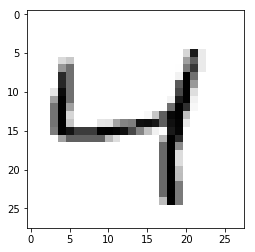

0
(784,)
(28, 28)


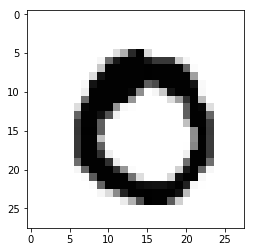

In [3]:
#plot 3rd and 57th training example
single = train[:, 2]
print(single[0])
single = single[1:]
print(single.shape)
single_image = single.reshape(28, 28)
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')
plt.show()

single = train[:, 56]
print(single[0])
single = single[1:]
print(single.shape)
single_image = single.reshape(28, 28)
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')
plt.show()


In [4]:
#separate labels and data
train_labels = train[0]
train_labels = train_labels.astype(np.float32)
m = train_labels.shape[0]
print(train_labels.reshape(1, train_labels.shape[0]))
temp = tf.constant(10, name='temp')
train_labels_temp = tf.one_hot(train_labels, temp, axis=0)
session = tf.Session()
train_labels = session.run(train_labels_temp)
session.close()
print(train_labels)
print(train_labels.shape)
print('')
train_data = train[1:, :]
train_data = train_data.astype(np.float32)
print(train_data)
print(train_data.shape)
print('')

test_labels = test[0]
train_labels = train_labels.astype(np.float32)
print(test_labels.reshape(1, test_labels.shape[0]))
temp = tf.constant(10, name='temp')
test_labels_temp = tf.one_hot(test_labels, temp, axis=0)
session = tf.Session()
test_labels = session.run(test_labels_temp)
session.close()
print(test_labels)
print(test_labels.shape)
print('')
test_data = test[1:, :]
test_data = test_data.astype(np.float32)
print(test_data)
print(test_data.shape)


[[ 5.  0.  4. ...,  5.  6.  8.]]
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(10, 60000)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(784, 60000)

[[7 2 1 ..., 4 5 6]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(10, 10000)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(784, 10000)


In [5]:
train_data = train_data.T
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.T
test_data = test_data.reshape(-1, 28, 28, 1)
train_labels = train_labels.T
test_labels = test_labels.T


In [6]:
def mini_batches(x, y, mini_batch_size=64):
    
    m = x.shape[0]                  # number of training examples
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation, :]
    complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(0, complete_minibatches):
        mini_batch_x = shuffled_x[k*mini_batch_size: k*mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_y = shuffled_y[k*mini_batch_size: k*mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_x = shuffled_x[complete_minibatches * mini_batch_size: m, :, :, :]
        mini_batch_y = shuffled_y[complete_minibatches * mini_batch_size: m, :]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
y = tf.placeholder(dtype=tf.float32, shape=[None, 10])
w1 = tf.get_variable('w1', [4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable('w2', [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer())

In [8]:
with tf.device('/gpu:0'):
    def forw(x):
        z1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='SAME')
        a1 = tf.nn.relu(z1)
        p1 = tf.nn.max_pool(a1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        z2 = tf.nn.conv2d(p1, w2, strides=[1, 1, 1, 1], padding='SAME')
        a2 = tf.nn.relu(z2)
        p2 = tf.nn.max_pool(a2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        z3 = tf.contrib.layers.flatten(p2)
        z4 = tf.contrib.layers.fully_connected(z3, 256, activation_fn=None)
        z5 = tf.contrib.layers.fully_connected(z4, 10, activation_fn=None)
    
        return z5

In [9]:
with tf.device('/gpu:0'):
    def compute_cost(z, y):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=(z), labels=(y)))
        return cost

In [16]:
with tf.device('/gpu:0'):
    def model(x_train, y_train, x_test, y_test, alpha, iterations, minibatch_size):
        
        (m, n_H0, n_W0, n_C0) = x_train.shape             
        n_y = y_train.shape[1]                            
        costs = []
        z = forw(x)
        cost = compute_cost(z, y)
        optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
        init = tf.global_variables_initializer()
        pbar = tqdm(total=iterations)
        
        with tf.Session() as sess:
            sess.run(init)
            for i in range(iterations):
                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)
                minibatches = mini_batches(x_train, y_train, minibatch_size)
    
                for minibatch in minibatches:
                    (minibatch_x, minibatch_y) = minibatch
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={x: minibatch_x, y: minibatch_y})
                    minibatch_cost += temp_cost / num_minibatches
                    
                if i%10 == 0:
                    print("iteration: %2d | cost: %8f" % (i, minibatch_cost))
                costs.append(minibatch_cost)
                pbar.update(1)
                
            plt.plot(np.squeeze(costs))
            plt.show()
            
            out = tf.nn.softmax(z)
            pred = tf.argmax(out, axis=1)
            preds = tf.equal(pred, tf.argmax(y, 1))
            crp = tf.reduce_sum(tf.cast(preds, "float"))
            correct_pred = 0
            mini = mini_batches(x_train, y_train)
            for minib in mini:
                (mx, my) = minib
                correct_pred += crp.eval({x: mx, y: my})
            
            print('Train accuracy: ' + str(float(100*correct_pred)/x_train.shape[0]))
            correct_pred = 0
            mini = mini_batches(x_test, y_test)
            for minib in mini:
                (mx, my) = minib
                correct_pred += crp.eval({x: mx, y: my})
            
            print('Test accuracy: ' + str(float(100*correct_pred)/x_test.shape[0]))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

iteration:  0 | cost: 1.475066
iteration: 10 | cost: 0.054162
iteration: 20 | cost: 0.037696
iteration: 30 | cost: 0.031818
iteration: 40 | cost: 0.032538


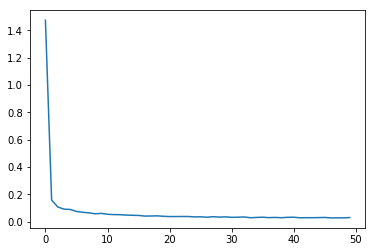

Train accuracy: 99.47166666666666
Test accuracy: 98.43


In [17]:
model(x_train=train_data, y_train=train_labels, x_test=test_data, y_test=test_labels, alpha=0.001, iterations=50, minibatch_size=64)